# MNIST Training
## Day 3

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
# DataLoader是用于加载数据集的模块
import torchvision
# transforms是数据预处理模块，用于将图像转换为张量，并进行归一化
import torchvision.transforms as transforms
# datasets是用于加载数据集的模块
from torchvision import datasets
# DataLoader是用于加载数据集的模块
from torch.utils.data import DataLoader  # 添加这一行


import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import matplotlib.patheffects as path_effects
import os
import torch.utils.data as data


### Q: datasets和Dataloader的区别是什么?
#### datasets 和 DataLoader 的区别

##### 1. datasets（数据集类）
作用：定义和加载数据集，提供对原始数据的访问。
特点：
负责数据获取、下载、存储
应用数据预处理（如 transform）
返回一个数据集对象，包含所有样本
可通过索引访问单个样本：dataset[0] 返回一个样本

<pre>
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
# train_ds 包含所有 60,000 个训练样本
# 可以通过 train_ds[0] 访问第一个样本（图像和标签）
</pre>

##### 2. DataLoader（数据加载器）
作用：将数据集包装成可迭代的批次，用于训练循环。
特点：
将数据集分成批次（batch）
支持多进程加载（num_workers）
支持打乱顺序（shuffle）
支持内存固定（pin_memory，用于 GPU 加速）
返回一个迭代器，每次迭代返回一个批次的数据
示例：
<pre>
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
# train_loader 将 60,000 个样本分成多个批次，每批 128 个样本
# 在训练循环中使用：
for images, labels in train_loader:
    # images: [128, 1, 28, 28] 形状的张量（128个图像）
    # labels: [128] 形状的张量（128个标签）
    # 进行训练...
</pre>

##### 3. 关系和工作流程
原始数据 → datasets.MNIST → 数据集对象 → DataLoader → 批次迭代器 → 训练循环
         (加载和预处理)    (所有样本)    (分批处理)    (批量数据)
在我们的代码中：
<pre>
# 步骤1: 创建数据集（包含所有样本）
train_ds = datasets.MNIST(...)  # 60,000 个样本

# 步骤2: 创建数据加载器（将数据集分批）
train_loader = DataLoader(train_ds, batch_size=128, ...)  # 约 469 个批次

# 步骤3: 在训练中使用
for batch_images, batch_labels in train_loader:
    # 每次循环处理 128 个样本
    pass
</pre>

##### 4. 简单类比
datasets = 图书馆（存放所有书籍）
DataLoader = 借书系统（每次借出几本书，可以按顺序或随机借）
总结：datasets 负责数据的定义和访问，DataLoader 负责将数据组织成批次供训练使用。两者配合使用，datasets 提供数据源，DataLoader 提供高效的批量加载机制

#### Task 0: 使用合适的device(cuda,mps,cpu)

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

#### Task 1: 进行数据预处理，download并加载MNIST数据集

In [5]:
# 数据预处理
# 将图像转换为张量，并进行归一化
# 0.1307 是 MNIST 数据集的均值，0.3081 是 MNIST 数据集的标准差, 这两个数据是从MNIST数据集的官方网站上获取的，如果之后的数据集没有这些公开数据，则需要重新计算
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# ds是数据集的缩写，train_ds是训练数据集，val_ds是验证数据集
# 从MNIST数据集官网下载数据集，并进行预处理
# 下载的数据集会保存在./data/MNIST文件夹下
# 我们已经有数据集了，所以不需要下载，因此先检查是否存在    
 # 如果数据集不存在，则从MNIST数据集官网下载数据集
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
val_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)


#### Task 2: 手动检查训练集的形状

In [6]:
# 手动查看数据集里的内容
print(f"训练集大小: {len(train_ds)}")
print(f"验证集大小: {len(val_ds)}")
print(f"图像形状: {train_ds[0][0].shape}")
print(f"type of the lablel: {type(train_ds[0][1])}")
print(train_ds[0][0][0].shape)

训练集大小: 60000
验证集大小: 10000
图像形状: torch.Size([1, 28, 28])
type of the lablel: <class 'int'>
torch.Size([28, 28])


#### Question 1: train_ds是一个什么样的结构？

(4, 4)
<class 'numpy.ndarray'>
<class 'matplotlib.figure.Figure'>


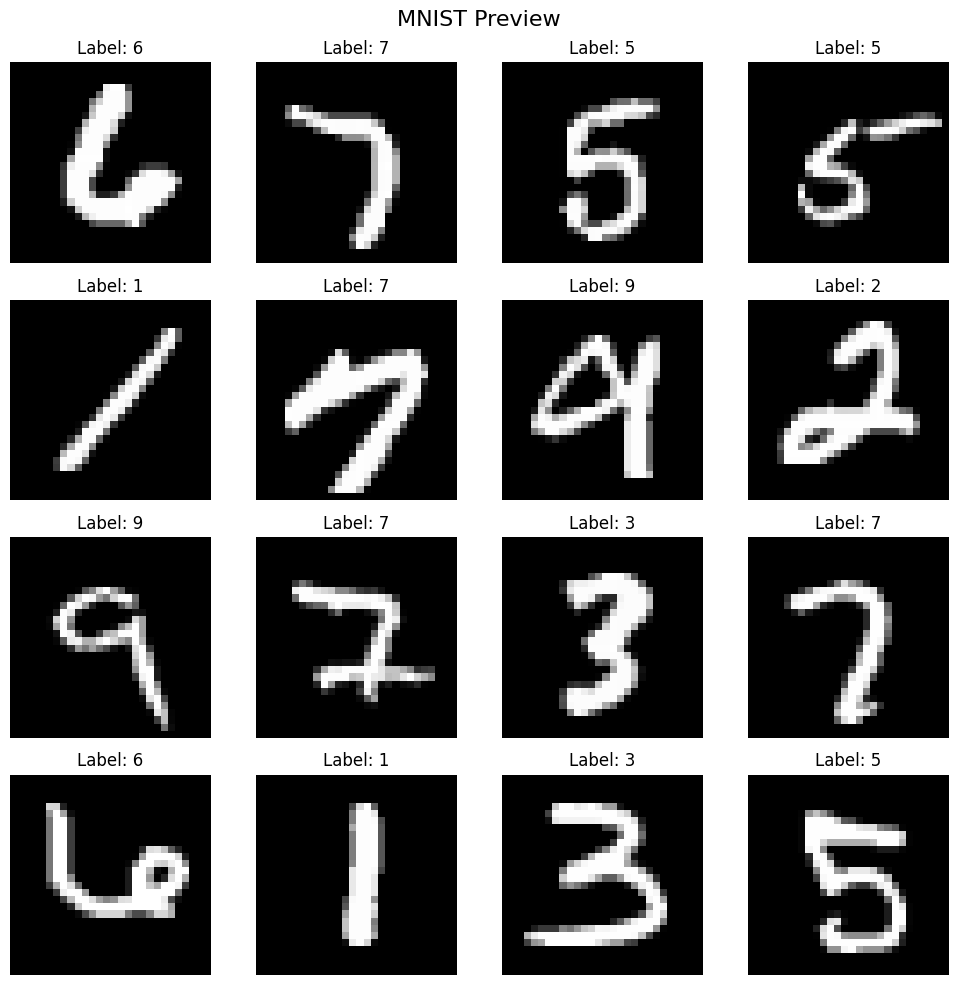

In [8]:
# 可视化数据集样本
# 注意：由于图像已经归一化，需要反归一化才能正确显示
def denormalize(tensor, mean=0.1307, std=0.3081):
    """反归一化函数"""
    return tensor * std + mean

# dataset: 数据集对象, num_sumples: 显示的样本数量, title: 图像的标题
def show_image(dataset, num_sumples=16, title="MNIST Preview"):
    """Show a 4x4 grid of MNIST images with their labels"""
    # fig: 创建一个图像对象, axes: 创建一个4x4的子图对象, figsize: 设置图像的大小
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)
    # 遍历axes的每个子图，显示图像和标签
    print(axes.shape)
    print(type(axes))
    print(type(fig))

    # 随机选择num_sumples个样本
    indices = np.random.choice(len(dataset), num_sumples, replace=False)

    # 遍历axes的每个子图，显示图像和标签
    # axes.flat: 将axes展平成一维数组(此处为4x4=16个元素)
    # ax: 每个子图对象
    for idx, ax in enumerate(axes.flat):
        image, label = dataset[indices[idx]]
        # reverse the normalization
        image = denormalize(image)
    
        # transform the image to numpy array and remove the channel dimension
        # image.shape[0] 是图像的通道数, 1表示灰度图像, 3表示彩色图像
        if image.shape[0] == 1:
            image = image.squeeze(0)

        # show image
        ax.imshow(image.numpy(), cmap='gray')
        ax.set_title(f'Label: {label}', fontsize=12)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# 显示训练集样本
show_image(train_ds)

#### Question 2: Why we should normailize the image?

In [9]:
# A minimal example of softmax regression
import torch
import torch.nn as nn
import torch.optim as optim

class LinearMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        # fc1: full connected layer 1, 将28*28的图像展平成784维的向量，然后输入到全连接层1中
        # self.fc1 不是函数，而是一个对象（nn.Linear 的实例）。
        self.fc1 = nn.Linear(28*28, 10)

    def forward(self, x):
        # x: [batch_size, 1, 28, 28]
        # view: a function that reshape the tensor
        # -1: the batch size is not known, so we use -1 to let the tensor know the batch size
        x = x.view(-1, 28*28)
        # fc1: full connected layer 1, 将784维的向量输入到全连接层1中
        x = self.fc1(x)
        return x

model = LinearMNIST().to(device)

In [ ]:
# This is a manual implementation of the linear layer

class LinearMNISTManual():
    def __init__(self) -> None:
        super().__init__()
        # not using nn.Linear, because we want to implement the forward and backward manually
        # weight: [28 * 28, 10]
        # bias: [10]
        self.weight = torch.nn.Parameter(torch.randn(28 * 28, 10))
        self.bias = torch.nn.Parameter(torch.randn(10))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # the output shape is [batch_size, 10]
        return x @ self.weight + self.bias
    
    def backward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        
        

#### Question 3: What is self.fc1 and how it is called?
##### `self.fc1` 是什么？

**`self.fc1` 不是函数，而是一个对象（`nn.Linear` 的实例）。**

##### 语法解析：`self.fc1 = nn.Linear(28*28, 10)`

这行代码做了两件事：

1. **创建对象**：`nn.Linear(28*28, 10)` 创建了一个 `Linear` 类的实例
   - `nn.Linear` 是一个类（不是函数）
   - 调用时创建了一个全连接层对象
   - 该对象包含权重矩阵（形状 [784, 10]）和偏置向量（形状 [10]）

2. **赋值给属性**：`self.fc1 = ...` 将这个对象赋值给 `self.fc1`
   - `self.fc1` 现在是一个 `Linear` 对象
   - 它是模型的一个属性/组件

##### 为什么可以像函数一样调用？

虽然 `self.fc1` 是对象，但可以像函数一样调用（如 `self.fc1(x)`），因为：

- PyTorch 的 `nn.Module` 实现了 `__call__` 方法
- 当你写 `self.fc1(x)` 时，Python 会调用 `self.fc1.__call__(x)`
- `__call__` 内部会调用 `self.fc1.forward(x)` 执行实际计算
- 这叫做“可调用对象”（Callable Object）

##### 为什么用对象而不是函数？

- 需要存储状态：权重和偏置需要在训练过程中更新
- 参数管理：PyTorch 需要追踪和管理这些参数，以便优化器更新
- 模块化：对象可以组合成更复杂的网络结构

##### 类比理解

- 函数 = 工具（比如锤子），每次使用都一样
- 对象 = 工具箱（包含锤子和其他工具），可以存储状态（比如锤子的重量）
- `self.fc1 = nn.Linear(...)` = 创建一个工具箱
- `self.fc1(x)` = 使用工具箱中的工具

**总结**：`self.fc1` 是一个 `Linear` 对象，可以像函数一样调用，但它能存储和更新权重、偏置等参数，这是函数做不到的。

In [10]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
# SGD: stochastic gradient descent
optimizer = optim.SGD(model.parameters(), lr=0.1)

#### Question 4: What is a optimizer?

##### 什么是 Optimizer（优化器）？

**优化器（Optimizer）是用于更新神经网络参数的算法工具。** 训练时，它根据损失函数的梯度调整模型参数（权重和偏置），使模型逐步改进。

##### 代码解析：`optimizer = optim.SGD(model.parameters(), lr=0.1)`

这行代码创建了一个 SGD（随机梯度下降）优化器：

1. **`optim.SGD`**：SGD 优化器类
   - SGD = Stochastic Gradient Descent（随机梯度下降）
   - 一种常用的优化算法

2. **`model.parameters()`**：传入需要优化的参数
   - 返回模型中所有可训练参数（权重和偏置）
   - 优化器会更新这些参数

3. **`lr=0.1`**：学习率（Learning Rate）
   - 控制每次参数更新的步长
   - 0.1 表示每次按梯度的 10% 更新参数
   - 学习率太大可能不稳定，太小可能训练慢

##### 优化器的作用

训练过程通常包括：

1. **前向传播**：输入数据，计算预测结果
2. **计算损失**：比较预测和真实标签，计算损失
3. **反向传播**：计算损失对每个参数的梯度
4. **更新参数**：优化器使用梯度更新参数

优化器负责第 4 步：根据梯度更新参数。

##### 常见优化器类型

- **SGD**：基础方法，简单稳定
- **Adam**：自适应学习率，通常收敛更快
- **AdamW**：Adam 的改进版本
- **RMSprop**：自适应学习率方法

##### 优化器的工作流程

1. 初始化：创建优化器时，记录需要优化的参数
2. 训练循环中：
   - 计算损失和梯度（通过 `loss.backward()`）
   - 调用 `optimizer.step()` 更新参数
   - 调用 `optimizer.zero_grad()` 清零梯度（为下次迭代准备）

##### 类比理解

把训练比作下山找最低点：
- **损失函数** = 山的高度（越低越好）
- **梯度** = 当前位置最陡的方向
- **优化器** = 决定如何沿这个方向移动
- **学习率** = 每次移动的步长

SGD 就是：沿着最陡方向，每次移动固定步长（由学习率决定）。

##### 总结

`optimizer = optim.SGD(model.parameters(), lr=0.1)` 创建了一个 SGD 优化器，用于在训练过程中更新模型参数。学习率 0.1 控制更新步长。优化器是训练神经网络的关键组件，负责根据梯度调整参数，使模型逐步改进。

In [11]:
# 设置模型为训练模式
# further task: implement the function train() by myself
model.train()
# 计算总损失
total_loss = 0

# x: [batch_size, 1, 28, 28], y: [batch_size]
for step, (x, y) in enumerate(train_loader):
    # to(device): 将数据移动到GPU上
    x = x.to(device)
    y = y.to(device)

    # model(x): [batch_size, 10]
    logits = model(x)
    loss = criterion(logits, y)

    # zeri_grad(): initialize the gradient
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # loss function
    total_loss += loss.item()
    # print the loss every 100 steps
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

print(f"Total Loss: {total_loss / len(train_loader)}")


Step 0, Loss: 2.5803942680358887
Step 100, Loss: 0.3034222722053528
Step 200, Loss: 0.393673300743103
Step 300, Loss: 0.48768478631973267
Step 400, Loss: 0.22222034633159637
Total Loss: 0.3748248949615178


##### Task:
1. implement the train() function manually
2. implement the foward and backward function manually
3. change the size of the training data (don't use the full training set but a part of it)

In [12]:
model.eval()
correct = 0
total = 0

# 使用 torch.no_grad() 上下文管理器，禁用梯度计算
# 在评估模式下，不需要计算梯度，可以加快计算速度
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        
        logits = model(x)
        pred = logits.argmax(dim=1)
        
        correct += (pred == y).sum().item()
        total += y.size(0)

        val_acc = correct / total

print(f"Accuracy of the model on the {total} val images: {100 * correct / total}%")
        

Accuracy of the model on the 10000 val images: 90.53%
